## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Use color transforms, gradients, etc., to create a thresholded binary image.
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import libraries

In [102]:
import os
import cv2
import glob
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline


## 1. Camera calibration using chessboard images

In [24]:
def camera_calibration(image_tmpl, output_dir='.'):
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    h, w = 6, 9
    obj_pt = np.zeros((h*w, 3), np.float32)
    obj_pt[:, :2] = np.mgrid[0:w, 0:h].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    obj_pts = [] # 3d points in real world space
    img_pts = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(image_tmpl)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (w, h), None)

        if ret == True:
            obj_pts.append(obj_pt)
            img_pts.append(corners)

    # Do camera calibration given object points and image points
    img = cv2.imread(images[0])
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = \
        cv2.calibrateCamera(obj_pts, img_pts, img_size, None, None)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    output_file = os.path.join(output_dir, 'dist_pickle.p')
    pickle.dump(dist_pickle, open(output_file, 'wb'))
    return (mtx, dist)
    
mtx, dist = camera_calibration('camera_cal/calibration*.jpg')

## 2. Undistort raw image

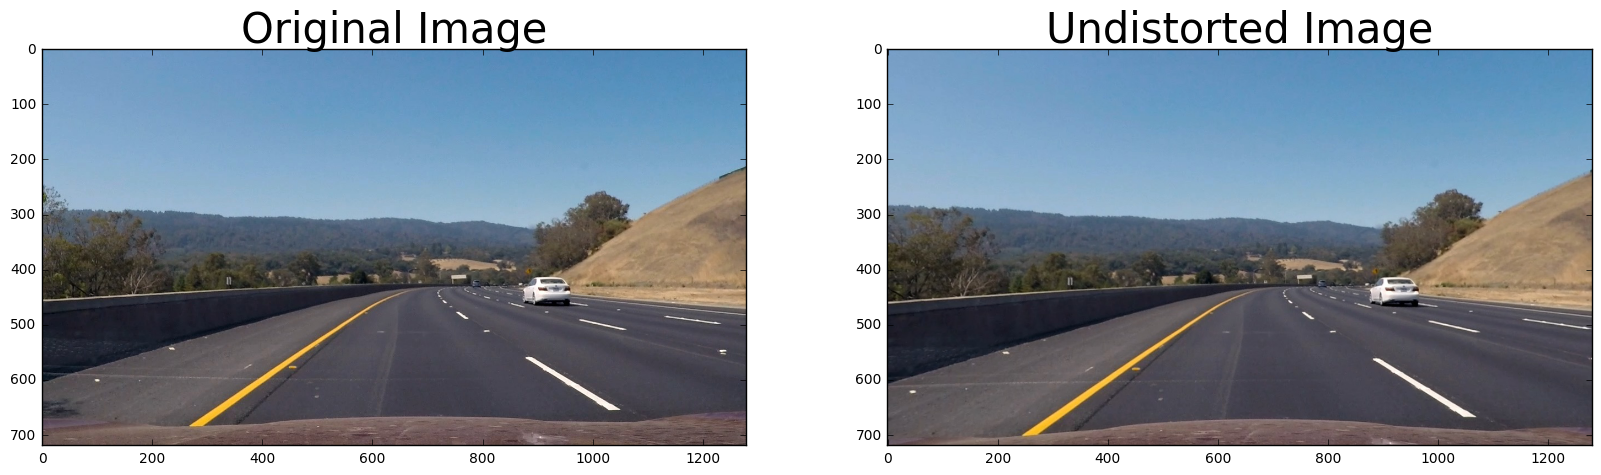

In [130]:
def load_undistort_params(input_dir='.'):
    input_file = os.path.join(input_dir, 'dist_pickle.p')
    dist_pickle = pickle.load(open(input_file, 'rb'))
    return (dist_pickle['mtx'], dist_pickle['dist'])

def undistort_image(image, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

# Test undistortion on an image
img = cv2.imread('test_images/test3.jpg')
mtx, dist = load_undistort_params()
dst = undistort_image(img, mtx, dist)
cv2.imwrite('test_images/test3_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

## 3. Perspective transform

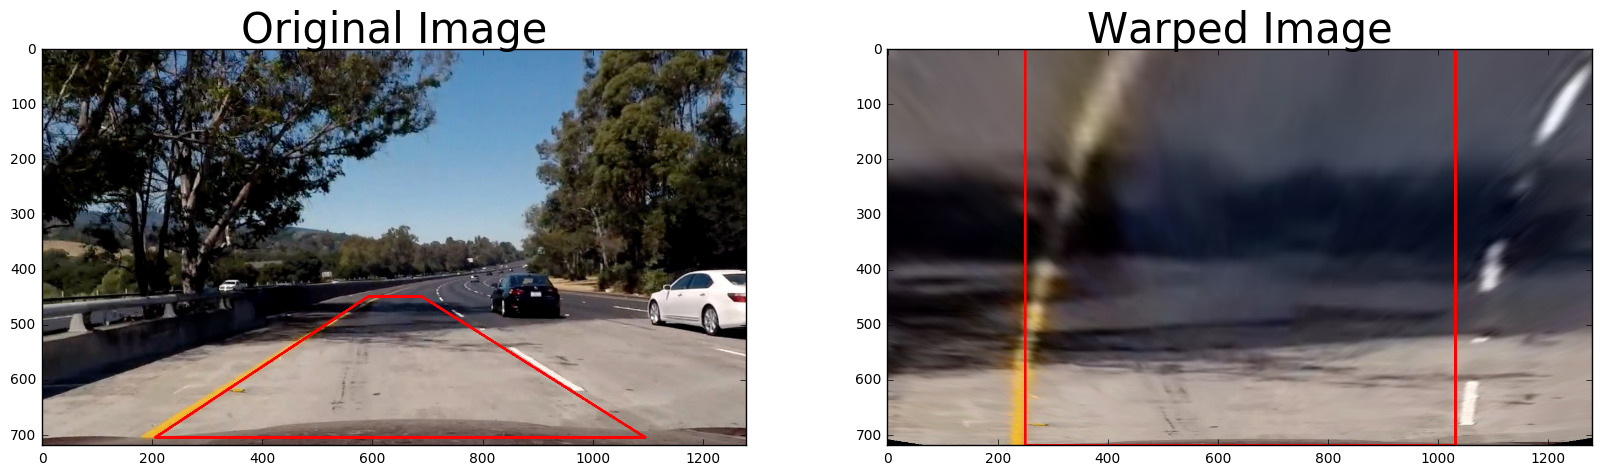

In [243]:
def perspective_transform(image):
    
    src = np.float32([(592, 450), (689, 450), (205, 706), (1095, 706)])
    #dst = np.float32([(350, 0), (930, 0), (350, 720), (930, 720)])
    dst = np.float32([(250, 0), (1030, 0), (250, 720), (1030, 720)])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, None, flags=cv2.INTER_LINEAR)
    
    return warped, M

dst = cv2.imread('test_images/test5_undist.jpg')
warped, M = perspective_transform(dst)

# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
pts = np.array([(592, 450), (689, 450), (1095, 706), (205, 706)])
dst_line = dst.copy()
cv2.polylines(dst_line, [pts], True, (0, 0, 255), thickness=3)
ax1.imshow(cv2.cvtColor(dst_line, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)

#pts = np.array([(350, 0), (930, 0), (930, 720), (350, 720)])
pts = np.array([(250, 0), (1030, 0), (1030, 720), (250, 720)])
warped_line = warped.copy()
cv2.polylines(warped_line, [pts], True, (0, 0, 255), thickness=3)
ax2.imshow(cv2.cvtColor(warped_line, cv2.COLOR_BGR2RGB))
ax2.set_title('Warped Image', fontsize=30)

## 4. Create Threshold Binary Image (Color & Graident)

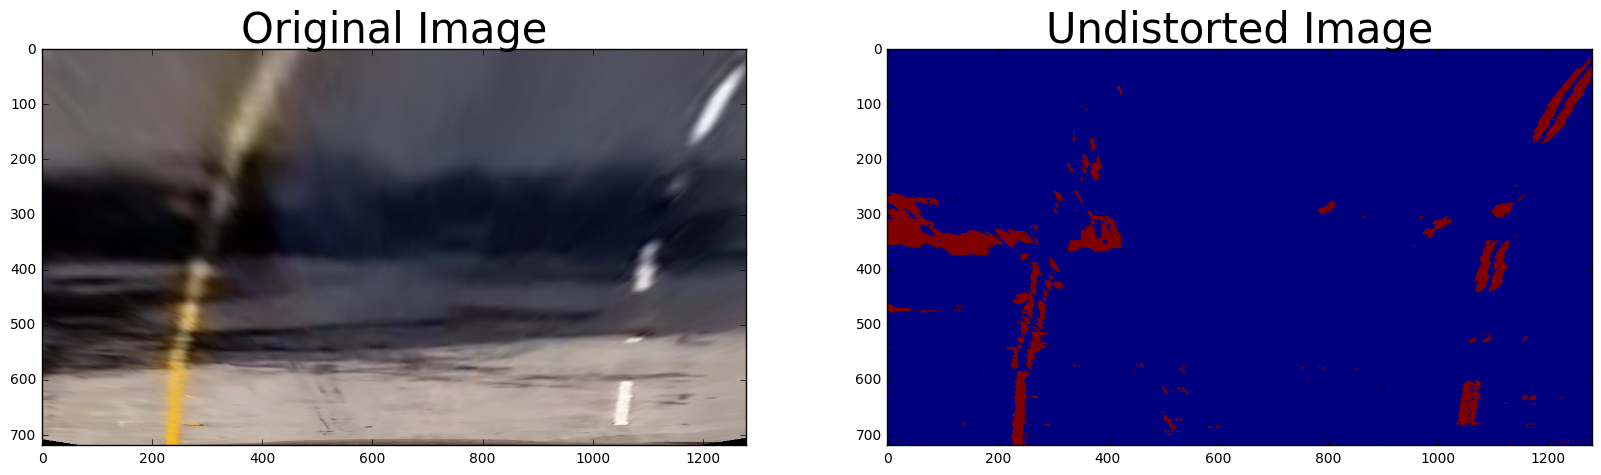

In [244]:
def create_threshold_binary_image(image, s_thresh=(170, 255), sx_thresh=(20, 100)):
    image = np.copy(image)
    
    # convert color space
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS).astype(np.float)
    l_ch = hls[:,:,1]
    s_ch = hls[:,:,2]
    
    # sobel x (derivative in x axis)
    sobelx = cv2.Sobel(l_ch, cv2.CV_64F, 1, 0)
    abs_sobelx = np.abs(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # threshold x gradient
    sx_mask = (scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])
    #sxbinary = np.zeros_like(scaled_sobel)
    #sxbinary[sx_mask] = 1
    
    # threshold color channel
    s_mask = (s_ch >= s_thresh[0]) & (s_ch <= s_thresh[1])
    #s_binary = np.zeros_like(s_ch)
    #s_binary[s_mask] = 1
    
    binary = np.zeros_like(scaled_sobel)
    binary[sx_mask | s_mask] = 1
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return binary
    #return color_binary

binary_img = create_threshold_binary_image(warped)
    
# Visualize transformed images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_img)
ax2.set_title('Undistorted Image', fontsize=30)

## 5. Find lane lines

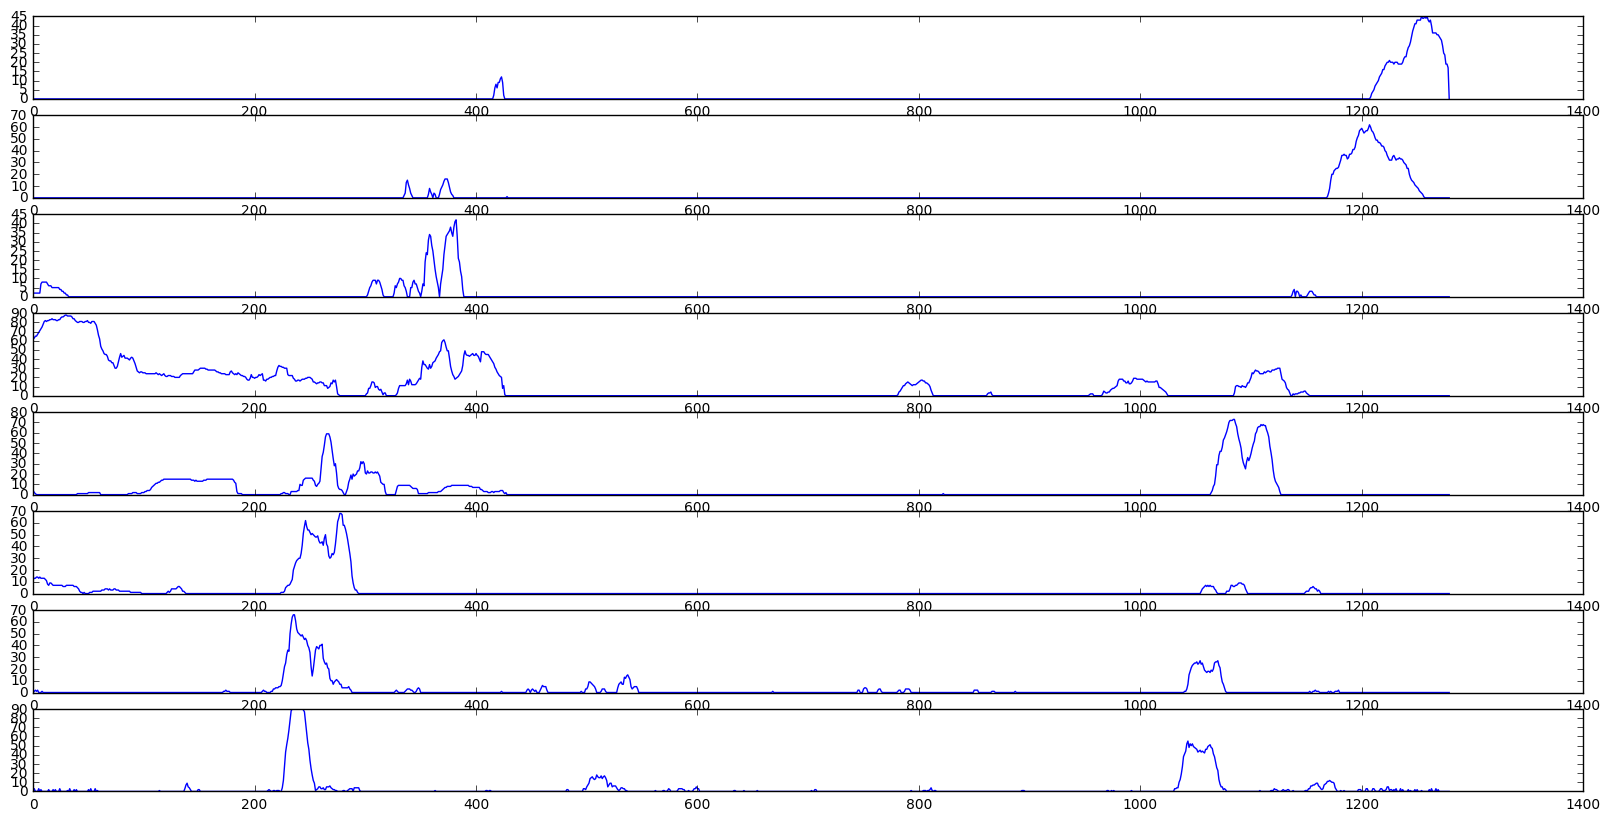

In [245]:
# Visiualize sliding window
nb_win = 8
height = binary_img.shape[0]
win_size = math.ceil(height/nb_win)

f, axes = plt.subplots(nb_win, 1, figsize=(20,10))
for i, ax in enumerate(axes):
    start = i * win_size
    end = start + win_size
    histogram = np.sum(binary_img[start:end,:], axis=0)
    ax.plot(histogram)

Lane line not found.
Lane line not found.
Lane line not found.


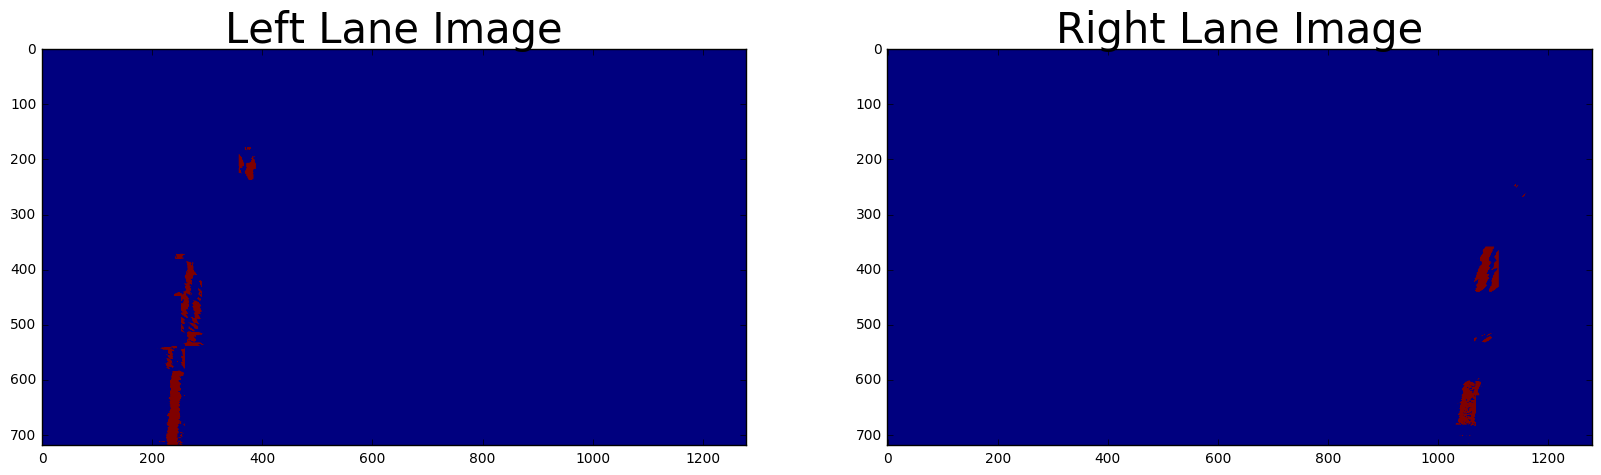

In [246]:
def find_lane_points(binary_image):
    """
    """
    lane_width = 25
    lanes_dist = 750
    tolerance  = 70

    mid = int(binary_img.shape[1]/2)
    height = binary_image.shape[0]
    
    nb_win = 8
    win_size = math.ceil(height/nb_win)

    l_y_vals = []
    l_x_vals = []
    
    r_y_vals = []
    r_x_vals = []
    
    l_pnts = np.zeros_like(binary_image)
    r_pnts = np.zeros_like(binary_image)
    
    l_peak = None
    r_peak = None
    
    found_first = False
    for i in range(nb_win):
        idx = (nb_win - 1) - i

        start = idx * win_size
        end = start + win_size

        histogram = np.sum(binary_image[start:end, :], axis=0)

        # bottom band
        if True or not found_first:
            l_peak = np.argmax(histogram[:mid])
            r_peak = np.argmax(histogram[mid:]) + mid

            # Valid lane line found
            if abs((r_peak - l_peak) - lanes_dist) < tolerance:
                l_mask = binary_image[start:end, l_peak-lane_width:l_peak+lane_width] == 1
                r_mask = binary_image[start:end, r_peak-lane_width:r_peak+lane_width] == 1
                l_pnts[start:end, l_peak-lane_width:l_peak+lane_width][l_mask] = 1
                r_pnts[start:end, r_peak-lane_width:r_peak+lane_width][r_mask] = 1
                found_first = True
            else:
                print('Lane line not found.')
        # rest bands
        else:
            pass
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(l_pnts)
    ax1.set_title('Left Lane Image', fontsize=30)
    ax2.imshow(r_pnts)
    ax2.set_title('Right Lane Image', fontsize=30)
    return np.where(l_pnts == 1), np.where(r_pnts == 1)

l_points, r_points = find_lane_points(binary_img)

## 6. Measure Curvature

809.443853947 5206.62158324


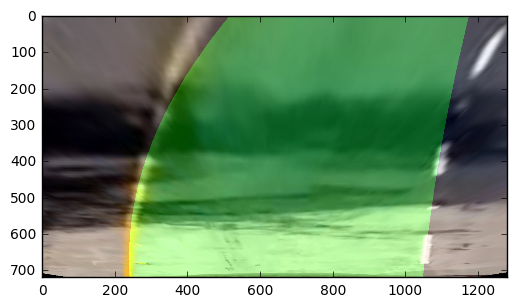

In [247]:
def fit_poly(x_vals, y_vals, y_max):
    # fit second order polynomial
    line_fit = np.polyfit(y_vals, x_vals, 2)
    
    # calculate radius of curvature
    curverad = ((1 + (2*line_fit[0]*y_max + line_fit[1])**2)**1.5) \
                             /np.absolute(2*line_fit[0])
    return line_fit, curverad

l_fit, l_curverad = fit_poly(l_points[1], l_points[0], height)
r_fit, r_curverad = fit_poly(r_points[1], r_points[0], height)
print (l_curverad, r_curverad)

# Create an image to draw the lines on
color_warp  = np.zeros_like(warped).astype(np.uint8)

# Recast the x and y points into usable format for cv2.fillPoly()
y_vals = np.linspace(0, 100, num=101)*7.2 
l_x_fit = l_fit[0]*y_vals**2 + l_fit[1]*y_vals + l_fit[2]
r_x_fit = r_fit[0]*y_vals**2 + r_fit[1]*y_vals + r_fit[2]

pts_left  = np.array([np.transpose(np.vstack([l_x_fit, y_vals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([r_x_fit, y_vals])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
result = cv2.addWeighted(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB), 1, color_warp, 0.3, 0)
plt.imshow(result)

### Line Class

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### Draw lines

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)